# 8. Neural Machine Translation (NMT)

![](https://summalinguae.com/wp-content/uploads/2019/12/automated-translation-bot-smartphone_EN.jpg)

## Objetivos

- Mostrar un pipeline completo para crear modelos de traducción automática neuronales
- Entrenar modelos pequeños
- Evaluación de modelos
    - BLEU
    - WER
- Deploy de modelos
    - GUI translations (streamlit)

La traducción automática ha tenido varios enfoques a lo largo de la historia

- Basado en reglas
- Basado en frecuencias y estadística
- Basados en redes neuronales

## Pipeline

### 0. Obtención de datos y preprocesamiento



- Para poder crear modelos de traducción automática necesitamos textos paralelos. Es decir textos en una lengua con su traducción
- Sin embargo, los métodos neuronales para crear modelos de traducción automática requieren muchisimos datos para funcionar
  - Se pueden usar corpus bilingües públicos como los que se pueden encontrar en OPUS: https://opus.nlpl.eu/
  - Con la herramienta de busqueda se pueden encontrar datos en varias lenguas
- En NMT es común usar el formato "Moses"
    - Dos archivos con lang code como extensión
    - Una sentencia por línea con concordancia con su traducción en la misma líena del otro archivo
- Es importante verificar como es el corpus que estamos utilizando
    - No todos los datasets tienen la misma calidad
    - Dependiendo de esta calidad se requerira más o menos preprocesamiento


#### Datasets de ejemplo

* EN-AR: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/ar-en.txt.zip
* EN-ES: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-es.txt.zip
* EN-FR: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-fr.txt.zip
* EN-RU: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-ru.txt.zip
* EN-ZH: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-zh.txt.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Creamos el directorio para nuestros archivos
%cd /content/drive/MyDrive/nmt/

/content/drive/MyDrive/nmt


In [3]:
# Clonamos el repositorio para herramientas de preprocesamiento
!git clone https://github.com/ymoslem/MT-Preparation.git

Cloning into 'MT-Preparation'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 268 (delta 133), reused 189 (delta 97), pack-reused 0
Receiving objects: 100% (268/268), 69.06 KiB | 1.77 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [4]:
# Install the requirements
!pip3 install -r MT-Preparation/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00


In [5]:
# Descarga del dataset y lo descomprimimos
!wget  https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-es.txt.zip
!unzip en-es.txt.zip

--2023-11-13 22:27:52--  https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-es.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9850684 (9.4M) [application/zip]
Saving to: ‘en-es.txt.zip’

en-es.txt.zip       100%[===================>]   9.39M  5.02MB/s    in 1.9s    

2023-11-13 22:27:55 (5.02 MB/s) - ‘en-es.txt.zip’ saved [9850684/9850684]

Archive:  en-es.txt.zip
  inflating: UN.en-es.en             
  inflating: UN.en-es.es             
  inflating: README                  


In [6]:
!tail UN.en-es.en

8. Notes with satisfaction the realization of the Cooperation for Rehabilitation Programme in Belarus and the Chernobyl Recovery and Development Programme in Ukraine, aimed at promoting better living conditions in and the sustainable development of the affected territories;
9. Also notes with satisfaction assistance rendered by the International Atomic Energy Agency to Belarus, the Russian Federation and Ukraine on remediation of agricultural and urban environments, cost-effective agricultural countermeasures and the monitoring of human exposure in areas affected by the Chernobyl disaster;
10. Takes note with satisfaction of the progress made by the Governments of the affected countries in implementing national strategies to mitigate the consequences of the Chernobyl disaster, and calls upon United Nations agencies and multilateral and bilateral donors to continue to align their assistance with the priorities of the national strategies of the affected States, and stresses the importanc

In [7]:
!tail UN.en-es.es

8. Observa con satisfacción la ejecución del Programa de Cooperación para la Rehabilitación en Belarús y del Programa de Recuperación y Desarrollo de Chernobyl en Ucrania, destinados a promover unas mejores condiciones de vida y el desarrollo sostenible en los territorios afectados;
9. Observa con satisfacción también la asistencia prestada por el Organismo Internacional de Energía Atómica a Belarús, la Federación de Rusia y Ucrania para mejorar el entorno agrícola y urbano, adoptar medidas agrícolas eficaces en función de su costo para contrarrestar los efectos del desastre de Chernobyl y vigilar la exposición de los seres humanos en las zonas afectadas;
10. Toma nota con satisfacción de los progresos realizados por los gobiernos de los países afectados en la aplicación de estrategias nacionales destinadas a mitigar las consecuencias del desastre de Chernobyl, hace un llamamiento a los organismos de las Naciones Unidas y a los donantes multilaterales y bilaterales para que sigan adapt

#### Filtrado de datos


- La herramienta filtra segmentos que pueden afectar la calidad de las traducciones
    - Segmentos vacios, segmentos duplicados entre otros

In [8]:
# Filter the dataset
# Arguments: source file, target file, source language, target language
!python3 MT-Preparation/filtering/filter.py UN.en-es.en UN.en-es.es en es

Dataframe shape (rows, columns): (74067, 2)
--- Rows with Empty Cells Deleted	--> Rows: 74067
--- Duplicates Deleted			--> Rows: 61123
--- Source-Copied Rows Deleted		--> Rows: 61046
--- Too Long Source/Target Deleted	--> Rows: 60332
--- HTML Removed			--> Rows: 60332
--- Rows will remain in true-cased	--> Rows: 60332
--- Rows with Empty Cells Deleted	--> Rows: 60332
--- Rows Shuffled			--> Rows: 60332
--- Source Saved: UN.en-es.en-filtered.en
--- Target Saved: UN.en-es.es-filtered.es


In [9]:
!wc -l UN.en-es.en-filtered.en

60332 UN.en-es.en-filtered.en


In [10]:
!wc -l UN.en-es.es-filtered.es

60332 UN.en-es.es-filtered.es


#### Tokenization / Sub-wording


- Recordemos que para aplicaciones robustaz de NLP necesitamos aplicar sub-word tokenization
  - En este caso dadas las limitaciones de memoria/computo el modelo esta limitado en la cantidad de tokens que puede aprender
  - Para resolver este problema se usan sub-words en lugar de palabras completas
- Hay que considerar que al trabajar con sub-words cuando querramos realizar traducciones necesitaremos aplicar un proceso de "desubword" para tener el texto plano

In [11]:
!ls MT-Preparation/subwording/

1-train_bpe.py	1-train_unigram.py  2-subword.py  3-desubword.py


In [12]:
# Train a SentencePiece model for subword tokenization
!python3 MT-Preparation/subwording/1-train_unigram.py UN.en-es.en-filtered.en UN.en-es.es-filtered.es

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=UN.en-es.en-filtered.en --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --split_digits=true
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: UN.en-es.en-filtered.en
  input_format: 
  model_prefix: source
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
 

In [13]:
!ls

en-es.txt.zip	README	      target.model  UN.en-es.en-filtered.en  UN.en-es.es-filtered.es
MT-Preparation	source.model  UN.en-es.en   UN.en-es.es


In [14]:
# Subword the dataset
!python3 MT-Preparation/subwording/2-subword.py source.model target.model UN.en-es.en-filtered.en UN.en-es.es-filtered.es

Source Model: source.model
Target Model: target.model
Source Dataset: UN.en-es.en-filtered.en
Target Dataset: UN.en-es.es-filtered.es
Done subwording the source file! Output: UN.en-es.en-filtered.en.subword
Done subwording the target file! Output: UN.en-es.es-filtered.es.subword


In [15]:
# Primeras 2 lineas sin subwordZ}|
!head -n 3 UN.en-es.en-filtered.en && echo "-----" && head -n 3 UN.en-es.es-filtered.es

11. Welcomes the cooperation between the United Nations and the Organization for the Prohibition of Chemical Weapons within the framework of the Relationship Agreement between the United Nations and the Organization, in accordance with the provisions of the Convention;
Noting further the work of the Intergovernmental Panel on Climate Change and the need to build and enhance scientific and technological capabilities, inter alia, through continuing support to the Panel for the exchange of scientific data and information, especially in developing countries, and noting the pending release of the fourth assessment report,
23. Reasons shall be given for any refusal of mutual legal assistance.
-----
11. Celebra la cooperación entre las Naciones Unidas y la Organización para la Prohibición de las Armas Químicas en el marco del acuerdo en que se definen las relaciones entre las Naciones Unidas y dicha organización, de conformidad con las disposiciones de la Convención;
Observando además la labo

In [16]:
# First 3 lines after subwording
!head -n 10 UN.en-es.en-filtered.en.subword && echo "---" && tail -n 10 UN.en-es.es-filtered.es.subword

▁ 1 1 . ▁Welcomes ▁the ▁cooperation ▁between ▁the ▁Unit ed ▁Nations ▁and ▁the ▁Organization ▁for ▁the ▁Prohibition ▁of ▁Chemical ▁Weapons ▁within ▁the ▁framework ▁of ▁the ▁Relationship ▁Agreement ▁between ▁the ▁Unit ed ▁Nations ▁and ▁the ▁Organization , ▁in ▁accord ance ▁with ▁the ▁provisions ▁of ▁the ▁Convention ;
▁Noting ▁further ▁the ▁work ▁of ▁the ▁In tergovernmental ▁Panel ▁on ▁C limate ▁Change ▁and ▁the ▁need ▁to ▁build ▁and ▁enhance ▁scientific ▁and ▁technological ▁capabilities , ▁inter ▁alia , ▁through ▁continuing ▁support ▁to ▁the ▁Panel ▁for ▁the ▁exchange ▁of ▁scientific ▁data ▁and ▁information , ▁ espec ially ▁in ▁developing ▁countries , ▁and ▁noting ▁the ▁ pending ▁release ▁of ▁the ▁fourth ▁assessment ▁report ,
▁ 2 3 . ▁Reason s ▁shall ▁be ▁given ▁for ▁any ▁refusal ▁of ▁mutual ▁legal ▁assistance .
▁ 6 1 / 1 8 1 . ▁Strengthen ing ▁the ▁Unit ed ▁Nations ▁Crime ▁Prevention ▁and ▁Criminal ▁Justice ▁Programme , ▁in ▁particular ▁its ▁technical ▁cooperation ▁capacity
▁Recalling ▁

#### Data Splitting

El corpus se particionará en 3 porciones:

1. `train`: Parte usada para entrenar el modelo
2. `dev`: Parte usada para validaciones durante el entrenamiento del modelo
3. `test`: Parte utilizada para evaluar que tan bueno es el modelo


In [17]:
# Split the dataset into training set, development set, and test set
# Development and test sets should be between 1000 and 5000 segments (here we chose 2000)
!python3 MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 UN.en-es.en-filtered.en.subword UN.en-es.es-filtered.es.subword

Dataframe shape: (60332, 2)
--- Empty Cells Deleted --> Rows: 60332
--- Wrote Files
Done!
Output files
UN.en-es.en-filtered.en.subword.train
UN.en-es.es-filtered.es.subword.train
UN.en-es.en-filtered.en.subword.dev
UN.en-es.es-filtered.es.subword.dev
UN.en-es.en-filtered.en.subword.test
UN.en-es.es-filtered.es.subword.test


In [18]:
# Line count for the subworded train, dev, test datatest
!wc -l *.subword.*

    2000 UN.en-es.en-filtered.en.subword.dev
    2000 UN.en-es.en-filtered.en.subword.test
   56332 UN.en-es.en-filtered.en.subword.train
    2000 UN.en-es.es-filtered.es.subword.dev
    2000 UN.en-es.es-filtered.es.subword.test
   56332 UN.en-es.es-filtered.es.subword.train
  120664 total


In [19]:
# Check the first and last line from each dataset
!echo "---First line---"
!head -n 1 *.{train,dev,test}

!echo -e "\n---Last line---"
!tail -n 1 *.{train,dev,test}

---First line---
==> UN.en-es.en-filtered.en.subword.train <==
▁ 1 1 . ▁Welcomes ▁the ▁cooperation ▁between ▁the ▁Unit ed ▁Nations ▁and ▁the ▁Organization ▁for ▁the ▁Prohibition ▁of ▁Chemical ▁Weapons ▁within ▁the ▁framework ▁of ▁the ▁Relationship ▁Agreement ▁between ▁the ▁Unit ed ▁Nations ▁and ▁the ▁Organization , ▁in ▁accord ance ▁with ▁the ▁provisions ▁of ▁the ▁Convention ;

==> UN.en-es.es-filtered.es.subword.train <==
▁ 1 1 . ▁Celebra ▁la ▁cooperación ▁entre ▁las ▁Naciones ▁Unidas ▁y ▁la ▁Organización ▁para ▁la ▁Prohibi ción ▁de ▁las ▁Armas ▁ Q uímicas ▁en ▁el ▁marco ▁del ▁acuerdo ▁en ▁que ▁se ▁define n ▁las ▁ relaciones ▁entre ▁las ▁Naciones ▁Unidas ▁y ▁dicha ▁organización , ▁de ▁conformidad ▁con ▁las ▁disposiciones ▁de ▁la ▁Convención ;

==> UN.en-es.en-filtered.en.subword.dev <==
▁Recalling ▁Economic ▁and ▁Social ▁Council ▁resolution ▁ 2 0 0 6 / 4 9 ▁of ▁ 2 8 ▁July ▁ 2 0 0 6 , ▁in ▁which ▁the ▁Council ▁requested ▁the ▁Unit ed ▁Nations ▁Forum ▁on ▁Forests ▁to ▁conclude ▁and ▁ado

In [9]:
!pip install OpenNMT-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 22.8 MB/s eta 0:00:00


### 1. Configuraciones del modelo

- El modelo que vamos a entrenar es un transformer (ver [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762))
    - Parametros recomendados para modelos entrenados con millones de sentencias:
        - `train_steps`: valores entre `100,000` y `200,000` o más
            - Habilitar `early_stopping`
        - `valid_steps`: `10,000` si `train_steps` es suficientemente grande
        - `warmup_steps`: entre `4000` y `8000`
            - Debe ser menor o igual que `train_steps`
- Consideremos que tenemos un dataset pequeño por lo que debemos ajustar los parametros a esta realidad
    - `train_steps=3000`
    - `valid_steps=1000`
    - `warmup_steps=1000`
- Más información de los parametros válidos en la [documentación de entrenamiento](https://opennmt.net/OpenNMT-py/options/train.html)


In [21]:
# Creación del archivo de configuración
# Usando valores pequeños en vista de que tenemos un corpus limitado
# Para datasets grandes deberian aumentar los valores:
# train_steps, valid_steps, warmup_steps, save_checkpoint_steps, keep_checkpoint
SRC_DATA_NAME = "UN.en-es.en-filtered.en.subword"
TARGET_DATA_NAME = "UN.en-es.es-filtered.es.subword"

config = f'''# config.yaml

## Where the samples will be written
save_data: run

# Rutas de archivos de entrenamiento
#(previamente aplicado subword tokenization)
data:
    corpus_1:
        path_src: {SRC_DATA_NAME}.train
        path_tgt: {TARGET_DATA_NAME}.train
        transforms: [filtertoolong]
    valid:
        path_src: {SRC_DATA_NAME}.dev
        path_tgt: {TARGET_DATA_NAME}.dev
        transforms: [filtertoolong]

# Vocabularios (serán generados por `onmt_build_vocab`)
src_vocab: source.vocab
tgt_vocab: target.vocab

# Tamaño del vocabulario
#(debe concordar con el parametro usado en el algoritmo de subword tokenization)
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filtrado sentencias de longitud mayor a n
# actuara si [filtertoolong] está presente
src_seq_length: 150
src_seq_length: 150

# Tokenizadores
src_subword_model: source.model
tgt_subword_model: target.model

# Archivos donde se guardaran los logs y los checkpoints de modelos
log_file: train.log
save_model: models/model.enes

# Condición de paro si no se obtienen mejoras significativas
# despues de n validaciones
early_stopping: 4

# Guarda un checkpoint del modelo cada n steps
save_checkpoint_steps: 1000

# Mantiene los n ultimos checkpoints
keep_checkpoint: 3

# Reproductibilidad
seed: 3435

# Entrena el modelo maximo n steps
# Default: 100,000
train_steps: 3000

# Corre el set de validaciones (*.dev) despues de n steps
# Defatul: 10,000
valid_steps: 1000

warmup_steps: 1000
report_every: 100

# Numero de GPUs y sus ids
world_size: 1
gpu_ranks: [0]

# Batching
bucket_size: 262144
num_workers: 0
batch_type: "tokens"
batch_size: 4096
valid_batch_size: 2048
max_generator_batches: 2
accum_count: [4]
accum_steps: [0]

# Configuración del optimizador
model_dtype: "fp16"
optim: "adam"
learning_rate: 2
# warmup_steps: 8000
decay_method: "noam"
adam_beta2: 0.998
max_grad_norm: 0
label_smoothing: 0.1
param_init: 0
param_init_glorot: true
normalization: "tokens"

# Configuración del Modelo
encoder_type: transformer
decoder_type: transformer
position_encoding: true
enc_layers: 6
dec_layers: 6
heads: 8
hidden_size: 512
word_vec_size: 512
transformer_ff: 2048
dropout_steps: [0]
dropout: [0.1]
attention_dropout: [0.1]
'''

with open("/content/drive/MyDrive/nmt/practica/config.yaml", "w+") as config_yaml:
  config_yaml.write(config)

In [24]:
!cat /content/drive/MyDrive/nmt/practica/config.yaml

# config.yaml

## Where the samples will be written
save_data: run

# Rutas de archivos de entrenamiento
#(previamente aplicado subword tokenization)
data:
    corpus_1:
        path_src: UN.en-es.en-filtered.en.subword.train
        path_tgt: UN.en-es.es-filtered.es.subword.train
        transforms: [filtertoolong]
    valid:
        path_src: UN.en-es.en-filtered.en.subword.dev
        path_tgt: UN.en-es.es-filtered.es.subword.dev
        transforms: [filtertoolong]

# Vocabularios (serán generados por `onmt_build_vocab`)
src_vocab: source.vocab
tgt_vocab: target.vocab

# Tamaño del vocabulario
#(debe concordar con el parametro usado en el algoritmo de subword tokenization)
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filtrado sentencias de longitud mayor a n
# actuara si [filtertoolong] está presente
src_seq_length: 150
src_seq_length: 150

# Tokenizadores
src_subword_model: source.model
tgt_subword_model: target.model

# Archivos donde se guardaran los logs y los checkpoints de m

#### Contruyendo el vocabulario

In [23]:
%%time
!onmt_build_vocab -config config.yaml -n_sample -1 -num_threads 2

2023-11-13 22:54:17.928330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 22:54:17.928402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 22:54:17.928443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 22:54:17.937760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 22:54:19.351699: W tensorflow/compiler/

- Debemos cambiar el tipo de entorno a uno con GPU

In [1]:
# Check if the GPU is active
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7d1cd0a3-efe2-7bc0-63b9-7d0f274b7070)


In [2]:
# Check if the GPU is visable to PyTorch

import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

gpu_memory = torch.cuda.mem_get_info(0)
print("Free GPU memory:", gpu_memory[0]/1024**2, "out of:", gpu_memory[1]/1024**2)

True
Tesla T4
Free GPU memory: 14998.8125 out of: 15101.8125


### 2. Entrenamiento

In [4]:
!ls

sample_data


In [ ]:
%%time
!onmt_train -config config.yaml

2023-11-11 05:19:21.447202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 05:19:21.447249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 05:19:21.447286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 05:19:21.455494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 05:19:22.760486: W tensorflow/compiler/

### 3. Traducción ⚛

Opciones para el modelo de traducción:
- `-model`: especifica el modelo con el checkpoint a usar
- `-src`: Dataset de test (tokenizado)
- `-output`: Archivo donde se guardarán las traducciones
- `-gpu`: Id de la GPU (usualmente 0), de otro modo la traducción se realiza en CPU
- `-min_length`: Para evitar traducciones vacias (opcional)
- `-verbose`: Si se quiere imprimir en pantalla las traducciones (opcional)

In [7]:
!head UN.en-es.en-filtered.en.subword.test

▁ 2 . ▁Requests ▁the ▁Secretary - General ▁to ▁take ▁the ▁appropriate ▁steps ▁to ▁establish ▁cooperation ▁between ▁the ▁Unit ed ▁Nations ▁and ▁the ▁Economic ▁Community ▁of ▁Central ▁African ▁States ;
▁Recalling ▁its ▁resolution ▁ 5 3 / 1 4 4 ▁of ▁ 9 ▁December ▁ 1 9 9 8 , ▁by ▁which ▁it ▁adopted ▁by ▁consensus ▁the ▁Declaration ▁on ▁the ▁Right ▁and ▁Responsibility ▁of ▁Individuals , ▁Groups ▁and ▁Organs ▁of ▁Society ▁to ▁Promot e ▁and ▁Protect ▁Universal ly ▁Recogniz ed ▁Human ▁Rights ▁and ▁F undamental ▁Freedoms , ▁annex ed ▁to ▁that ▁resolution ,
▁Noting ▁with ▁concern ▁the ▁problem ▁of ▁unemployment ▁on ▁the ▁island ▁and ▁the ▁joint ▁action ▁of ▁the ▁administer ing ▁Power ▁and ▁the ▁territorial ▁Government ▁to ▁deal ▁with ▁it ,
▁ 3 . ▁Encourages ▁the ▁Unit ed ▁Nations ▁Education al , ▁Scientific ▁and ▁Cultur al ▁Organization ▁to ▁continue ▁its ▁work ▁to ▁promote ▁a ▁greater ▁awareness ▁of ▁the ▁crucial ▁relationship ▁between ▁culture ▁and ▁development ;
▁ 1 . ▁Take s ▁note ▁of ▁the ▁

In [10]:
%%time
!onmt_translate -model models/model.enes_step_3000.pt -src UN.en-es.en-filtered.en.subword.test -output UN.es-practice.translated -gpu 0 -min_length 1

2023-11-13 23:04:24.669524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 23:04:24.669595: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 23:04:24.669646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 23:04:24.682089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 23:04:26.434905: W tensorflow/compiler/

In [20]:
!tail -n 40 UN.en-es.en-filtered.en.subword.test

▁ 5 . ▁A lso ▁welcomes ▁the ▁on going ▁efforts ▁of ▁UN - Habitat ▁to ▁develop ▁a ▁results - based ▁and ▁less ▁fragment ed ▁budget ▁structure ▁with ▁a ▁view ▁to ▁secur ing ▁maxim um ▁efficiency , ▁accountability ▁and ▁transparency ▁in ▁programme ▁delivery ▁regard less ▁of ▁funding ▁source ;
▁Hav ing ▁further ▁considered ▁the ▁report ▁of ▁the ▁Joint ▁Inspection ▁Unit ▁on ▁the ▁experience ▁of ▁Unit ed ▁Nations ▁system ▁organizations ▁with ▁results - based ▁budgeting ▁techniques , See ▁A / 5 4 / 2 8 7 . ▁as ▁well ▁as ▁the ▁comments ▁of ▁the ▁Secretary - General ▁thereon , See ▁A / 5 4 / 2 8 7 / Add . 1 .
▁ 1 0 . ▁Requests ▁the ▁Commissioner - General ▁to ▁proceed ▁with ▁the ▁issuance ▁of ▁identification ▁ cards ▁for ▁Palestine ▁refugees ▁and ▁their ▁descendants ▁in ▁the ▁O ccupied ▁Palestinian ▁Territory ;
▁ 3 . ▁Expresses ▁its ▁appreciation ▁to ▁th ose ▁Member ▁States ▁that ▁have ▁paid ▁their ▁assessed ▁contributions ▁in ▁full , ▁and ▁urges ▁all ▁other ▁Member ▁States ▁to ▁make ▁every ▁po

In [14]:
!tail UN.es-practice.translated

▁Aprobada ▁en ▁la ▁ 6 2 a ▁sesión ▁plenaria , ▁celebrada ▁el ▁ 8 ▁de ▁diciembre ▁de ▁ 2 0 0 5 , ▁por ▁recomendación ▁de ▁la ▁Comisión ▁( A / 6 0 / 4 7 6 , ▁párr . ▁ 2 2 ) El ▁proyecto ▁de ▁resolución ▁recomendado ▁en ▁el ▁informe ▁fue ▁patrocinado ▁en ▁la ▁Comisión ▁por ▁los ▁países ▁siguientes : ▁Alemania , ▁Arab ia ▁Saudita , ▁Argelia , ▁Bahr ein , ▁Bangladesh , ▁Bru nei ▁Darussalam , ▁Comoras , ▁Cuba , ▁Djibouti , ▁Egipto , ▁Emi ratos ▁Árabes ▁Unidos , ▁Guinea , ▁Indonesia , ▁Irán ▁( República ▁Islámica ▁del ), ▁Iraq , ▁Jordania , ▁Kuwait , ▁Líbano , ▁Malasia , ▁Malta , ▁Marruecos , ▁Namibia , ▁O mán , ▁ Q atar , ▁Senegal , ▁Somalia , ▁Sudáfrica , ▁Sudán , ▁Túnez , ▁Yemen ▁y ▁Palestina .
▁Aprobada ▁en ▁la ▁ 5 2 a ▁sesión ▁plenaria , ▁celebrada ▁el ▁ 1 9 ▁de ▁noviembre ▁de ▁ 2 0 0 2 , ▁sin ▁votación , ▁por ▁recomendación ▁de ▁la ▁Comisión ▁( A / 5 7 / 5 3 3 , ▁párr . ▁ 7 ) El ▁proyecto ▁de ▁resolución ▁recomendado ▁en ▁el ▁informe ▁fue ▁patrocinado ▁en ▁la ▁Comisión ▁por ▁los ▁países

In [11]:
!pip install -U -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00


In [16]:
!python MT-Preparation/subwording/3-desubword.py target.model UN.es-practice.translated

Done desubwording! Output: UN.es-practice.translated.desubword


In [19]:
!tail -n 40 UN.es-practice.translated.desubword

5. Acoge también con beneplácito los esfuerzos que está realizando el ONU-Hábitat para desarrollar una estructura de presupuesto basada en los resultados menos fragmentada y con miras a asegurar un máximo de eficiencia, responsabilidad y transparencia en la ejecución de los programas, con independencia de la fuente de financiación;
Habiendo examinado además el informe de la Dependencia Común de Inspección sobre la experiencia del sistema de las Naciones Unidas con los resultados de la planificación de la presupuestación basada en las técnicasVéase A/54/287., así como las observaciones del Secretario General al respectoVéase A/54/287/Add.1.,
10. Pide al Comisionado General que siga expidiendo documentos de identidad a los refugiados palestinos y a sus descendientes en el territorio palestino ocupado;
3. Expresa su reconocimiento a los Estados Miembros que han pagado sus cuotas íntegramente, e insta a todos los demás Estados Miembros a que hagan todo lo posible por pagar íntegramente sus

### Evaluación del modelo

- Hay muchas  métricas de evaluación y dependiendo del idioma puede que sea mejor usar unas u otras:
    - [BLEU](https://www.youtube.com/watch?v=M05L1DhFqcw)
    - METEOR
    - WER
    - Otras más

In [21]:
!git clone https://github.com/ymoslem/MT-Evaluation.git

fatal: destination path 'MT-Evaluation' already exists and is not an empty directory.


In [22]:
!pip install -r MT-Evaluation/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Aplicando desubword para tener la traducción de referencia
!python MT-Preparation/subwording/3-desubword.py target.model UN.en-es.es-filtered.es.subword.test

Done desubwording! Output: UN.en-es.es-filtered.es.subword.test.desubword


#### BLEU

In [23]:
!python MT-Evaluation/BLEU/compute-bleu.py UN.en-es.es-filtered.es.subword.test.desubword UN.es.translated.desubword

Reference 1st sentence: 2. Pide al Secretario General que adopte medidas adecuadas con el objeto de establecer la cooperación entre las Naciones Unidas y la Comunidad Económica de los Estados del África Central;
MTed 1st sentence: 2. Pide al Secretario General que adopte las medidas necesarias para establecer la cooperación entre las Naciones Unidas y la Comunidad Económica de los Estados del África Central;
BLEU:  63.86775552788015


#### METEOR

In [24]:
!python MT-Evaluation/WER/corpus-wer.py UN.en-es.es-filtered.es.subword.test.desubword UN.es.translated.desubword

WER Score: 0.3477828241529807


### Comparando con modelos averaged

- OpenNMT nos permite realizar el avg de modelos con el script [average_models.py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/bin/average_models.py)
- Compararemos si es mejor o pero el desempeño del nuevo modelo

In [25]:
!wget https://raw.githubusercontent.com/OpenNMT/OpenNMT-py/master/onmt/bin/average_models.py

--2023-11-13 23:15:09--  https://raw.githubusercontent.com/OpenNMT/OpenNMT-py/master/onmt/bin/average_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1651 (1.6K) [text/plain]
Saving to: ‘average_models.py.1’

average_models.py.1 100%[===================>]   1.61K  --.-KB/s    in 0.001s  

2023-11-13 23:15:10 (1.87 MB/s) - ‘average_models.py.1’ saved [1651/1651]



In [ ]:
!python average_models.py -models models/model.fren_step_1000.pt models/model.fren_step_2000.pt models/model.fren_step_3000.pt -output models/model_avg.pt

In [ ]:
%%time
!onmt_translate -model models/model_avg.pt -src UN.en-es.en-filtered.en.subword.test -output UN.es-averaged.translated -min_length 1

2023-11-11 18:54:42.732628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 18:54:42.732709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 18:54:42.732755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 18:54:42.745558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 18:54:44.542953: W tensorflow/compiler/

In [26]:
!head -n 10 UN.es-averaged.translated

▁ 2 . ▁Pide ▁al ▁Secretario ▁General ▁que ▁adopte ▁las ▁medidas ▁necesarias ▁para ▁establecer ▁la ▁cooperación ▁entre ▁las ▁Naciones ▁Unidas ▁y ▁la ▁Comunidad ▁Económica ▁de ▁los ▁Estados ▁del ▁África ▁Central ;
▁Recordando ▁su ▁resolución ▁ 5 3 / 1 4 1 , ▁de ▁ 9 ▁de ▁diciembre ▁de ▁ 1 9 9 8 , ▁en ▁la ▁que ▁aprobó ▁la ▁Declaración ▁sobre ▁el ▁derecho ▁y ▁el ▁deber ▁de ▁los ▁individuos , ▁los ▁grupos ▁y ▁las ▁instituciones ▁de ▁promover ▁y ▁proteger ▁los ▁derechos ▁humanos ▁y ▁las ▁libertades ▁fundamentales ▁universalmente ▁reconocidos , ▁que ▁figura ▁en ▁el ▁anexo ▁de ▁la ▁resolución ,
▁Observando ▁con ▁preocupación ▁el ▁problema ▁del ▁desempleo ▁en ▁la ▁isla ▁y ▁las ▁medidas ▁conjuntas ▁adoptadas ▁por ▁la ▁Potencia ▁administradora ▁y ▁el ▁Gobierno ▁del ▁Territorio ▁para ▁resolverlo ,
▁ 3 . ▁Alienta ▁a ▁la ▁Organización ▁de ▁las ▁Naciones ▁Unidas ▁para ▁la ▁Educación , ▁la ▁Ciencia ▁y ▁la ▁Cultura ▁a ▁que ▁prosiga ▁su ▁labor ▁para ▁promover ▁una ▁mayor ▁conciencia ▁de ▁la ▁relación ▁fu

In [27]:
!python MT-Preparation/subwording/3-desubword.py target.model UN.es-averaged.translated

Done desubwording! Output: UN.es-averaged.translated.desubword


In [28]:
!head -n 10 UN.es-averaged.translated.desubword

2. Pide al Secretario General que adopte las medidas necesarias para establecer la cooperación entre las Naciones Unidas y la Comunidad Económica de los Estados del África Central;
Recordando su resolución 53/141, de 9 de diciembre de 1998, en la que aprobó la Declaración sobre el derecho y el deber de los individuos, los grupos y las instituciones de promover y proteger los derechos humanos y las libertades fundamentales universalmente reconocidos, que figura en el anexo de la resolución,
Observando con preocupación el problema del desempleo en la isla y las medidas conjuntas adoptadas por la Potencia administradora y el Gobierno del Territorio para resolverlo,
3. Alienta a la Organización de las Naciones Unidas para la Educación, la Ciencia y la Cultura a que prosiga su labor para promover una mayor conciencia de la relación fundamental entre el desarrollo y la cultura de desarrollo;
1. Toma nota del informe del Grupo de Expertos Gubernamentales sobre la verificación en todos sus asp

In [29]:
# BLEU
!python MT-Evaluation/BLEU/compute-bleu.py UN.en-es.es-filtered.es.subword.test.desubword UN.es-averaged.translated.desubword

Reference 1st sentence: 2. Pide al Secretario General que adopte medidas adecuadas con el objeto de establecer la cooperación entre las Naciones Unidas y la Comunidad Económica de los Estados del África Central;
MTed 1st sentence: 2. Pide al Secretario General que adopte las medidas necesarias para establecer la cooperación entre las Naciones Unidas y la Comunidad Económica de los Estados del África Central;
BLEU:  56.4866183328863


In [30]:
# WER
!python MT-Evaluation/WER/corpus-wer.py UN.en-es.es-filtered.es.subword.test.desubword UN.es-averaged.translated.desubword

WER Score: 0.4183226111543501


### Optimizaciones y deploy a producción

Reducción del tamaño del modelo

In [ ]:
%%time
!onmt_release_model --model models/model.fren_step_3000.pt --output models/model_rc_v1.pt

2023-11-12 02:02:05.259174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 02:02:05.259249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 02:02:05.259288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 02:02:05.264781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 02:02:06.163149: W tensorflow/compiler/

Para obtener un modelo optimizado para traducciones on demand

In [31]:
!ct2-opennmt-py-converter --model_path models/model_rc_v1.pt --output_dir models/model_ct2_v3 --quantization int8

### DEMO time: streamlit

On my local machine because doesn't works on colab :p

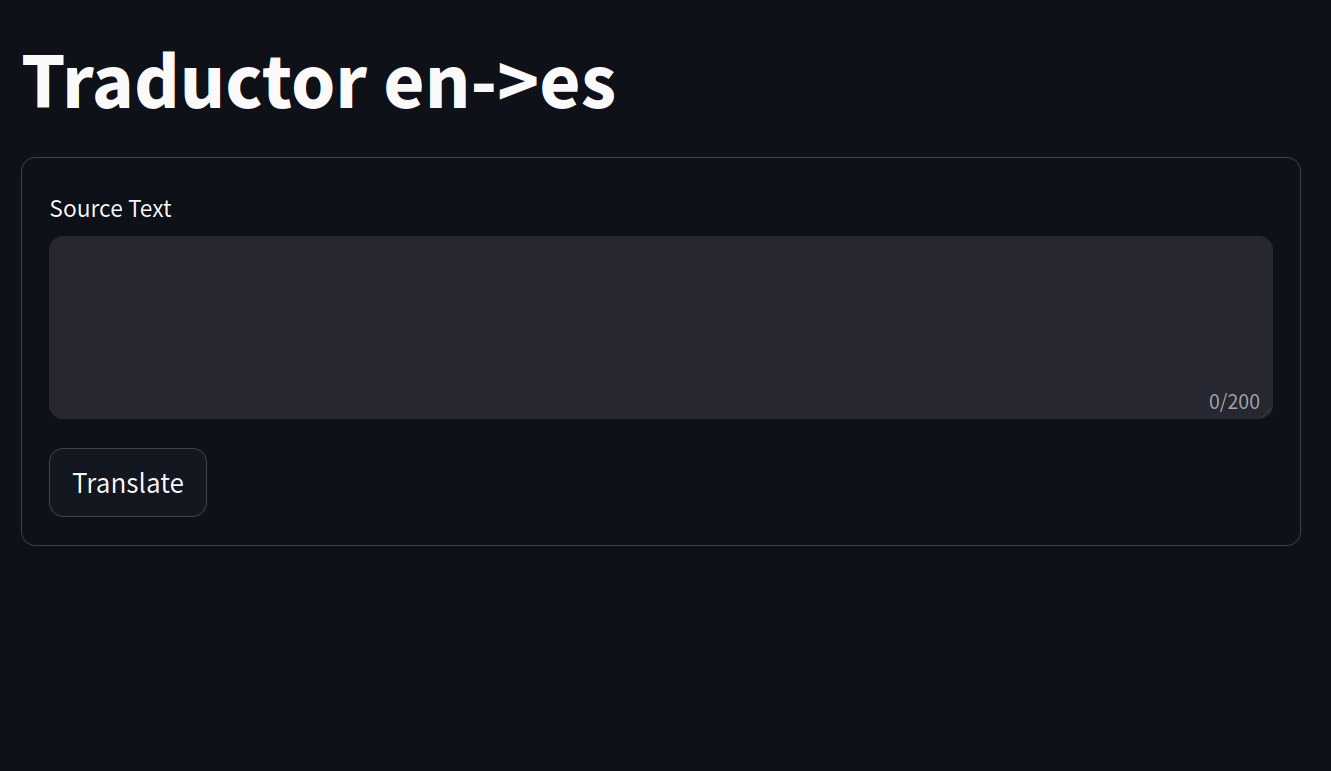

## Práctica 8: Modelos neuronales de traducción automática

**Fecha de entrega: 26 de noviembre 2023**

- Explorar los datasets disponibles en el *Shared Task de Open Machine Translation de AmericasNLP 2021*
    - [Datasets](https://github.com/AmericasNLP/americasnlp2021/tree/main/data)
    - [Readme](https://github.com/AmericasNLP/americasnlp2021/tree/main#readme)
- Crear un modelo de traducción neuronal usando OpenNMT-py y siguiendo el pipeline visto en clase
    - 0. Obtención de datos y preprocesamiento
        - Considerar que tiene que entrenar su modelo de tokenization
    - 1. Configuración y entrenamiento del modelo
    - 2. Traducción
    - 3. Evaluación
        - Reportar BLEU
        - Reportar ChrF (medida propuesta para el shared task)
        - Más info: [evaluate.py](https://github.com/AmericasNLP/americasnlp2021/blob/main/evaluate.py)        
- Comparar resultados con [baseline](https://github.com/AmericasNLP/americasnlp2021/tree/main/baseline_system#baseline-results)
- Incluir el archivo `*.translated`

### Extra

- Investigar porque se propuso la medida ChrF en el Shared Task
    - ¿Como se diferencia de BLEU?
    - ¿Porqué es reelevante utilizar otras medidas de evaluación además de BLEU?

## Referencias

- Esta práctica es una adaptación de una serie de notebooks públicos parte del proyecto Open NMT
    - [Data Processing](https://github.com/ymoslem/OpenNMT-Tutorial/blob/main/1-NMT-Data-Processing.ipynb)
    - [Model Training](https://github.com/ymoslem/OpenNMT-Tutorial/blob/main/2-NMT-Training.ipynb)
- Se usaron herramientas de ymoslem
    - https://github.com/ymoslem/MT-Preparation
    - https://github.com/ymoslem/MT-Evaluation
- [Transformers ilustrados](https://jalammar.github.io/illustrated-transformer/)

## Un update más

#### 3 de diciembre fecha maxima para entrega de practicas
#### Las practicas atrasadas sobre 6

![](https://cdn.suwalls.com/wallpapers/cartoons/thats-all-folks-7172-1920x1200.jpg)